# table of contents
TODO

## RMC for ODEs
### Basic construction
We ran some tests for 
$y'=y, y(0)=1$ with a basic Monte Carlo recursive scheme to build understanding. <br>

To do Monte Carlo you need a random variable $Y(t)$ which you can simulate such that $y(t) = E[Y(t)]$. To construct such a random variable you first need to turn the ODE into an integral equation which is easier to manipulate in this context. There are multiple techniques to do that (we will write it down later) in this case we want a recursive integral equation for theoretical reasons. This is easily obtained by integrating both sides.

$$
y(t)= 1 + \int_0^t y(s)ds.
$$
Do the following substitution in the integral $ds = \frac{ds}{dU} dU$ with $U = \text{Uniform}(0,t)$. (https://en.wikipedia.org/wiki/Radon%E2%80%93Nikodym_theorem $U$ is equivalent to $1_{[0,t]}$ you could interpret constants as random variables) Now you can write the integral as an expectation using reverse LOTUS (https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician).

$$
\begin{align*}
y(t)&= 1 + E[y(U) \frac{ds}{dU}]\\
&= 1 + tE[y(x) \mid U = x]\\
\end{align*}
$$
Suppose we can construct a family of random variables $Y(x)>0, 0<x<t$ (induction like) such that $y(x) = E[Y(x)]$. We will try to construct $Y(t)$ out of those. Sub this property in the previous equation.

$$
y(t)= 1 + tE[E[Y(x)] \mid U = x]
$$

Now merge the expectations (in this case it's ok because everything is positive).

$$
\begin{align*}
y(t)&= 1 + tE[Y(x) \mid U = x]\\
    &= 1 + tE[Y(U)]\\
    &= E[1 + tY(U)]
\end{align*}
$$
$1 + tY(U)$ has the property of the random variable we wanted to construct. To complete the construction we would need
to construct $Y(x)>0, 0<x<\varepsilon$ for an arbitrary $\varepsilon$. We haven't figured out how to do that but we approximate such random variable for small $\varepsilon$ with $1$ and test if it works.<br>
Following code demonstrates how to construct $Y(t)$ approximately using recursion.

In [2]:
from random import random
def Y(t,eps):
    return 1 + t* Y(random()*t,eps) if t>eps else 1 

sol = 0
nsim = 10**3
eps = 0.01
t = 1

for _ in range(nsim):
    sol += Y(t,eps)/nsim

print(f"exp({t}) is approx = {sol}")

exp(1) is approx = 2.758516570657602


To get clean convergence results we want $\text{Var}(Y(t)) < \infty$ but this is not necessary (later we will do an analysis of variance).
(https://en.wikipedia.org/wiki/Law_of_large_numbers)

### Modifications
Once we have a random variable where we can use Monte Carlo on there are tricks to manipulate that random variable such that the expectance is preserved but the behavior of the random variable changes. 

#### Russian Roulette
Russian Roulette is a popular technique in rendering (see Veach). The idea is accelerating simulation by "killing" low contribution simulations early and compesating by scaling surviving ones but this has as side effect increased variance. This can be achieved mathematically by adding bernoulli processes and scaling without changing the expectance. <br> 

In previous example we can change the recursive definition slightly by replacing $t$ with bernoulli process $B(t)$ for $t<1$ (this doesn't affect the expectance). Then the code becomes:

In [169]:
from random import random
from math import exp
def Y(t):
    return (1 + Y(random()*t) if 1-t<random() else 1) if t<1 else 1 + t* Y(random()*t)

sol = 0
nsim = 10**4
t = 5

for _ in range(nsim):
    sol += Y(t)/nsim

percentage_error = (sol - exp(t))/exp(t)

print(f"exp({t}) is approx = {sol}")
print(f"%error = {percentage_error}")

exp(5) is approx = 145.87086638244105
%error = -0.017129833604434153


We don't need to approximate our random variable for $\varepsilon$ because the simulation gets stopped by killing. Russian Roulette in this case got rid of a parameter, made our random variable unbiased and accelerated the program! 

#### Control Variates
Control variates is a widely used method to reduce variance in Monte Carlo methods. The idea is to subtract a similar random variable and add a other random variable with the same expectance. Often the expectance is known and the other random variable becomes a constant. (maybe we add an analysis of variance later)<br>

Let's go back to our example. It's a bit tricky to find a control variate for the whole family of random variables because adding a control variate influences higher order recursion calls. The only thing that should stay the same is that $y(t)=E[Y(t)]$ if we had an approximation of $y(t) \approx u(t)$ we can use that as a control variate. Let's go with a constant approximation of our solution $1$ because of our initial condition and $1+x$ for testing the case when the the expectance isn't known and estimated by Monte Carlo with $1$ simulation. 

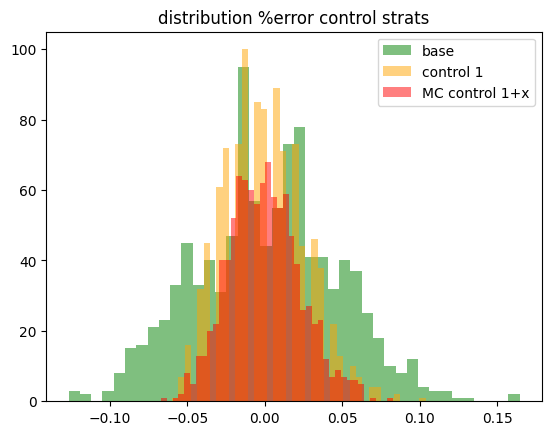

In [46]:
from random import random
from math import exp
import matplotlib.pyplot as plt

#Russian Roulette base
def Y(t):
    return (1 + Y(random()*t) if 1-t<random() else 1) if t<1 else 1 + t* Y(random()*t)

#Russian Roulette analytic control 1 
def Y1(t):
    return (1 + Y(random()*t)-1 + t if 1-t<random() else 1+t) if t<1 else 1 + t* (Y(random()*t)-1)+t

#Russian Roulette MC1 control 1+x 
def Y2(t):
    s = random()*t
    if t<1:
        return 1 + Y(s)-1-s+ t*(1+random()*t) if 1-t<random() else 1+ t*(1+random()*t)
    else:
        return 1 + t* (Y(s)-1-s) + t*(1+random()*t)


nsim = 10**2
t = 0.5
sols = []
sols1 = []
sols2 = []

for _ in range(1000):
    sol = 0
    sol1 = 0
    sol2 = 0
    for _ in range(nsim):
        sol += Y(t)/nsim
        sol1 += Y1(t)/nsim
        sol2 += Y2(t)/nsim
    sols.append((sol - exp(t))/exp(t))
    sols1.append((sol1 - exp(t))/exp(t))
    sols2.append((sol2 - exp(t))/exp(t))
data = [sols,sols1,sols2]

plt.hist(sols,bins=40,alpha = 0.5, color = "green",label="base")
plt.hist(sols1,bins =40,alpha = 0.5, color = "orange", label="control 1")
plt.hist(sols2, bins = 40, alpha = 0.5, color = "red", label= "MC control 1+x")
plt.legend()
plt.title("distribution %error control strats")
plt.show()

Control variates don't need to be static. In previous example a lot of information of $y$ can be extracted while doing simulations. Control variates that use information of simulations are adaptive control variates. Adaptive control variates can accelerate convergence complexity. (Later we will discuss orthonormal adaptive control variates)

Constant control variates alone usually don't increase performance but with Russian Roulette it does.

#### Importance Sampling
Importance sampling is also a widely used method to reduce variance in Monte Carlo methods. Remember the substitution with the uniform distribution that we did? The uniform distribution was an arbitrary choice we may have chosen any other distribution that was equivalent to $1_{[0,t]}$. Let's chose the distribution $\frac{dP}{ds} \sim x$ in our example:


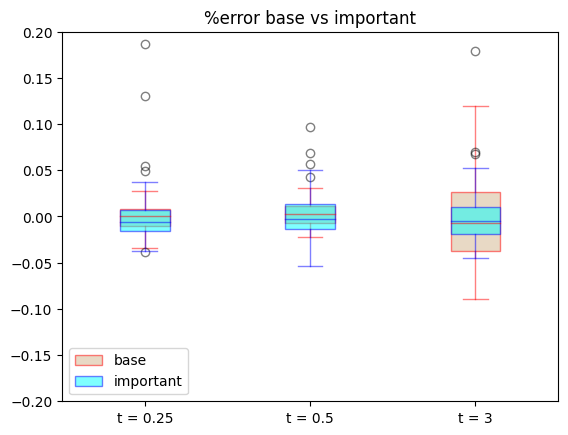

In [48]:
from random import random
from math import exp,sqrt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, alpha = 0.5)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
    return bp

#Russian Roulette base
def Y(t):
    return (1 + Y(random()*t) if 1-t<random() else 1) if t<1 else 1 + t* Y(random()*t)

#unreadable
#Russian Roulette importance sampling
def Y1(t):
    p = sqrt(random())*t
    if t<1:
        return 1 + t*Y1(p)/(p*2) if 1-t<random() else 1
    else:
        return 1 + t**2* Y1(p)/(p*2)

data = []
data1 = []
ts= [0.25,0.5,3]
for t in ts:
    nsim = 10**3
    sols = []
    sols1 = []

    for _ in range(100):
        sol = 0
        sol1 = 0
        for _ in range(nsim):
            sol += Y(t)/nsim
            sol1 += Y1(t)/nsim
        sols.append((sol - exp(t))/exp(t))
        sols1.append((sol1 - exp(t))/exp(t))
    data.append(sols)
    data1.append(sols1)

fig, ax = plt.subplots()
bp1 = box_plot(data, 'red', 'tan')
bp2 = box_plot(data1, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['base', 'important'])
ax.set_ylim(-0.2, 0.2)
plt.title("%error base vs important")
plt.xticks(ticks=[1,2,3],labels = [f"t = {t}" for t in ts])
plt.show()


This wasn't a fair comparison because importance sampling affect simulation lengths ...

#### Quasi Monte Carlo
Quasi Monte Carlo is a method to reduce variance in Monte Carlo. Remember how we used independent samples to estimate the expectance? Well the samples don't need to be $100\%$ independent.<br>

Gaussian quadrature rules (https://en.wikipedia.org/wiki/Gaussian_quadrature) are an efficient class of $n$-sample integrators that use a combination of importance sampling and carefully chosen sample points to increase performance on integrating a certain class of functions. <br>

To perform Quasi Monte Carlo you need to coordinate the samples in some way. In our example you can think of each simulation as a path and coordinating these paths of unequal length we find difficult.

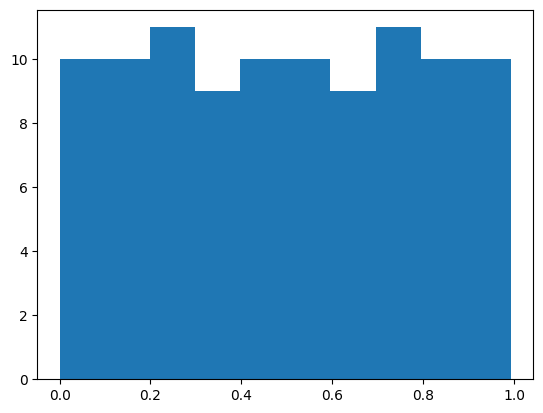

In [7]:
# code that we maybe are going to use?
from scipy.stats.qmc import Halton
import matplotlib.pyplot as plt

sampler = Halton(d=1)
sample = sampler.random(n=10**2)

#### Others
There are other techniques to modify the random variables in Monte Carlo but most of them can be replicated with a combination of previous techniques. Honorable mentions are 
- multilevel Monte Carlo (https://en.wikipedia.org/wiki/Multilevel_Monte_Carlo_method)
- stratified sampling (https://en.wikipedia.org/wiki/Stratified_sampling)
- ... (maybe we add more later)

### From ODEs to integral equations
Turning ODEs into integral equations makes getting random variables for Monte Carlo easier. We will introduce a technique for doing this with a series of examples. The basic idea is that linear differential operators can be kind of inverted with integral operators which can be constructed using a kind of basis (when these are dirac delta functions it reduces to something similar to the method of green functions https://en.wikipedia.org/wiki/Green%27s_function).
#### 1st order linear differential operators
In this example we will try convert the following equation into a integral equation:
$$
\begin{align*}
    y'+ay&=f \Leftrightarrow\\
    (D+a)y&=f
\end{align*}
$$
$y(0)=y_{0}$ where $f,a$ are integrable functions, $a$ doesn't depend on $y$ (maybe $f$ doesn't contain $y'$). For $1st$ order operators it is known that $D+a= e^{\int a} D e^{-\int a}$ which easily can be inverted but for the sake of the example we derive
this using steps of a more general approach. <br>

We first split our problem using following substitution $y= y_{h} + y_{p}$ a "homogeneous" part that captures initial/boundary conditions and a inhomogeneous part that captures the source term (this is like linear ODE theory but only if $f$ doesn't depend on $y$). This step may look obsolete but it will make life easier dealing with boundary conditions in the general case. 

$$
\begin{align*}
    (D+a)(y_{h}+y_{p})&=f \Leftrightarrow \\
    (D+a)y_{h}+(D+a)y_{p}&=f \Leftarrow \\
    (D+a)y_{h}&= 0 \text{ and} \\
    (D+a)y_{p}&=f
\end{align*}
$$

The boundary conditions: $y(0)=y_{0}= y_{h}(0) + y_{p}(0) \Leftarrow  y_{h}(0)=y_{0} \text{ and } y_{p}(0) = 0$. $y_{h}$ and $y_{p}$ are well defined (existence and uniqueness) when the original problem is well defined by Picard–Lindelöf theorem (https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem). <br>

$y_{h}$ is a solution of a linear homogeneous differential equation so can be written as a linear combination of basis solutions. It is easy to derive following expression:
$$
    y_{h}(t) = e^{\int_0^{t}a(s)ds}y(0)
$$
(Later we will discuss how to deal with $e^{\int_0^{t}a(s)ds}$ without solving it in Monte Carlo simulations.) <br>

$y_{p}$ in general can be found using green function with vanishing boundary/intial conditions. In this case we use the inverse of the linear operator which can be easily found with integrating factor (https://en.wikipedia.org/wiki/Integrating_factor): 

$$
\begin{align*}
   (D+a)y_{p} &= f \Leftrightarrow \\
   y_{p}(t) &= e^{\int_{0}^{t} a(s)ds} \int_{0}^{t} e^{-\int_{0}^{l} a(s)ds} f dl 
\end{align*}
$$

This results in following integral equation:
$$
y(t)= e^{\int_0^{t}a(s)ds}y(0)+e^{\int_{0}^{t} a(s)ds} \int_{0}^{t} e^{-\int_{0}^{l} a(s)ds} f dl 
$$



##### example
Let's go back and see how this applies to the first example. There various integral equations we can derive for this example.  Taking $a=0,f= y$ recovers the integral equation we first came up with. Taking $a = -1, f=0$ give a non recursive integral equation. Taking $a = -0.5,f=0.5y$ gives
$$ 
y(t)= e^{0.5t} + 0.5 e^{0.5t}\int_{0}^{t} e^{-0.5l} y(l)dl  
$$
Let's compare what the influence of $a$ is on the resulting Monte Carlo scheme (it looks stupid to calculate exp(t) using exp(t))

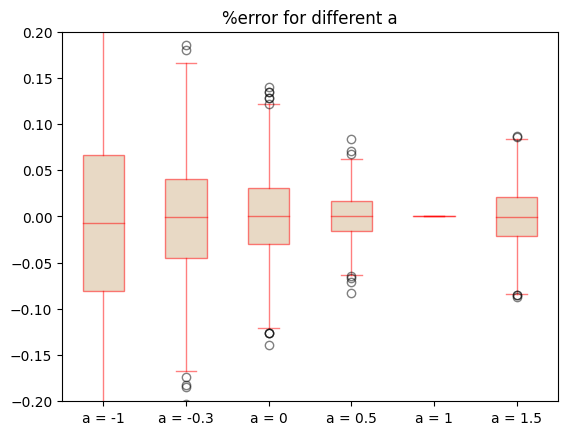

In [8]:
from random import random
from math import exp
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, alpha = 0.5)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
    return bp

def Y(t,a):
    s=random()*t
    if t<1:
        return exp(a*t) + (1-a)*exp(a*t)*exp(-a*s)*Y(s,a) if 1-t<random() else exp(a*t) 
    else:
        return exp(a*t) + (1-a)*t*exp(a*t)*exp(-a*s)*Y(s,a)
        

nsim = 10**2
t = 0.5
alist = [-1,-0.3,0,0.5,1,1.5]
data=[]

for a in alist:
    sols = []
    for _ in range(1000):
            sol = 0
            for _ in range(nsim):
                sol += Y(t,a)/nsim
            sols.append((sol - exp(t))/exp(t))
    data.append(sols) 


fig, ax = plt.subplots()
bp1 = box_plot(data, 'red', 'tan')
ax.set_ylim(-0.2, 0.2)
plt.title("%error for different a")
plt.xticks(ticks=range(1,len(alist)+1),labels = [f"a = {a}" for a in alist])
plt.show()

#### 2nd order differential operators
(TODO)
tricks:
- look at subproblem in domain
- recursion on derivatives
- maybe WoS example for PDEs + conjecture boundary green functions

## Non-Linearity
From the first example it's not clear how to deal with non-linearity. Again we work through examples to explain how to deal with non-linearity.

### Polynomials
A simple case of non-linearity are polynomials. Let's look to following example:
$$
y'= y^2
$$
with $y(1)=-1$. If you repeat the steps from the first example the place where you run into problems is when merging expectation:

$$
\begin{align*}
y(t) &= -1 + (t-1)E[E^{2}[Y(x)] \mid U = x] \\
    &= -1 + (t-1)E[E[Y(x)] E[Y(x)]\mid U = x]
\end{align*}
$$
in this case $U = \text{Uniform}(1,t)$. The trick to be able to take the expectation out is by replacing $1$ of the $Y(x)$ by a independent $\tilde{Y}(x)$ 

$$
\begin{align*}
y(t)&= -1 + (t-1)E[E[Y(x)] E[\tilde{Y}(x)]\mid U = x] \\
    &= -1 + (t-1)E[ E[Y(x) \tilde{Y}(x)]\mid U = x]\\
    &= -1 + (t-1)E[Y(U)\tilde{Y}(U)] \\
    &= E[ -1 + (t-1)Y(U)\tilde{Y}(U)] 
\end{align*}
$$
Let's implement this in code:

In [34]:
from random import random
def Y(t):
    if t>2:
        raise Exception("this doesn't support higher t")
    u = random()*(t-1)+1
    return -1 + Y(u)*Y(u) if random()<t-1 else -1 # Y(u)**2 != Y(u)*Y(u) !!!

sol = 0
nsim = 10**4
t = 1.5

for _ in range(nsim):
    sol += Y(t)/nsim

s = -1/t
percentage_error = (sol - s)/s

print(f"sol({t}) is approx = {sol}")
print(f"%error = {percentage_error}")

sol(1.5) is approx = -0.6691999999999426
%error = 0.0037999999999139833


This can be easily generalized to higher order polynomials. Note that in nonlinear problems modifications are key. Without controlling the amount of recursion calls with Russian Roulette you will have to do exponential recursion calls and control variates are way more effective on higher order terms. <br> 

Now that we dealt with polynomials we have an approximate way to deal with continous functions by the Weierstrass approximation theorem (https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem).

### Analytic Functions
There is a nice way to deal with analytic functions in an unbiased way. Basically you can do Russian Roulette to terminate a taylor series reducing it to a polynomial. Remember that we said we were going to discuss how to deal with $e^{\int_0^{t}a(s)ds}$? Let's do it. <br>

The beginning point is the taylor series of $e^{x}$:
$$
\begin{align*}
e^{E[X]} &= \sum_{n} \frac{E^{n}[X]}{n!}\\
      &= 1 + \frac{1}{1}E[X](1+ \frac{1}{2}E[X](1+\frac{1}{3}E[X](1+ ...)))
\end{align*}
$$
Change the fractions to Bernoulli processes and replace all $X$ with independent $X_i$ with $E[X]=E[X_{i}]$.

$$
\begin{align*}
e^{E[X]}&= 1 + B(\frac{1}{1})E[X_1](1+ B(\frac{1}{2})E[X_2](1+B(\frac{1}{3})E[X_3](1+ ...)))\\ 
      &= E[1 + B(\frac{1}{1})X_1(1+ B(\frac{1}{2})X_2(1+B(\frac{1}{3})X_3(1+ ...)))]\\ 
      
\end{align*}
$$
What is inside the expectation is something that we can simulate. We haven't done an analysis of variance yet. Let's code up a Monte Carlo scheme for $e^{-\int_0^t{xdx}}$ with this technique:

In [63]:
from random import random
from math import exp

def X(t):
    return -t*t*random()

#this calculate the depth of Bernoulli = 1
def amount_bernoulli():
    i = 1
    while random()*i<1:
        i+=1
    return i-1

#if the Bernoulli's are 1 you have a recursive structure in the def
def res(n,estimator):
    return 1 + estimator()*res(n-1,estimator) if n != 0 else 1    

def expE(estimator):
    return res(amount_bernoulli(),estimator)
    
nsim = 10**3
sol = 0
# this example works well for -1.5<t<1.5
t = 1.5

def Y():
    return X(t)

for _ in range(nsim):
    sol += expE(Y)/nsim

exact = exp(-t**2/2)
print("%error=",(sol- exact)/exact)

%error= 0.012528783413970243


## Other Applications
The techniques that we have so far can be used to build/modify other algorithms.

### Linear Systems 
(see test period1 RMC for linear system)

### Stochastic Fixpoint Example
Following code solves
$$
x = \frac{1}{1-\frac{1}{8}x}
$$

In [1]:
from random import random

def amount_bernoulli():
    return amount_bernoulli() + 1 if random()<1/4 else 0
    
def res(n,estimator):
    return 1+0.5*estimator()*res(n-1,estimator) if n>0 else 1
    
amount_of_recursive_calls=0
def X():
    global amount_of_recursive_calls
    amount_of_recursive_calls += 1
    return res(amount_bernoulli(),X)

def x(n):
    return 1/(1-(x(n-1))/8) if n>0 else 1.5
    
nsim = 10**3
sol = 0

for _ in range(nsim):
    sol+=X()/nsim

exact = x(10**3)
print("%error = ",(sol-exact)/exact)
print("#average amount of recursive calls =",amount_of_recursive_calls/nsim)

%error =  -0.0005428997666106146
#average amount of recursive calls = 1.508


#average amount of recursive calls is deceiving measure for parallel speed, parallel speed should be measured in longest recursion call and that is in this case difficult to measure.

## Further Work
TODO:
- variance analysis
- orthonormal adaptive control variates
- importance sampling tricks
- DIY stochastic trust region method
- Volterra, Fredholm integral equations?
- diffusion type PDEs with efficient Brownian simulation + compressing